In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

df = pd.read_csv("./data/train.csv")

In [2]:
"""
pre-processing
"""

# R and C
from sklearn.preprocessing import LabelEncoder

df["rnc"] = df["R"].astype(str) + '_' + df["C"].astype(str)
le_rnc = LabelEncoder()
le_rnc.fit(df.loc[:, "rnc"])
df.loc[:, "rnc"] = le_rnc.transform(list(df.loc[:, "rnc"]))

# time diff
df.rename({"time_step": "t"}, axis=1, inplace=True)
df["t_m1"] = df.groupby("breath_id")["t"].shift(-1)
df["dt"] = df["t_m1"] - df["t"]
df["dt"].fillna(method='ffill', inplace=True)
df["dt2"] = df["dt"] ** 2

# u_in - future and past values, 1st diff, and 1st derivative
df["u_in_m1"] = df.groupby("breath_id")["u_in"].shift(-1).fillna(method="ffill")
df["u_in_p1"] = df.groupby("breath_id")["u_in"].shift(1).fillna(method="bfill")
df["d1_u_in"] = df["u_in"] - df["u_in_p1"]
df["prime1_u_in"] = df["d1_u_in"] / df["dt"]

# integration
df["int1_u_in"] = (df["u_in"] * df["dt"]).cumsum()
df["int2_u_in"] = (df["int1_u_in"] * df["dt"]).cumsum()

"""
re-scaling
"""
from sklearn.preprocessing import StandardScaler

#scaling_keys = ["pressure", "u_in", "d1_u_in", "d2_u_in", "prime1_u_in", "prime2_u_in", "int1_u_in", "int2_u_in"]
#scalers = {}
#for key in scaling_keys:
#    scaler = StandardScaler()
#    scaler.fit(df[[key]])
#    df[[key]]= scaler.transform(df[[key]])
#    scalers[key] = scaler
    
# pressure past
df["pressure_p1"] = df.groupby("breath_id")["pressure"].shift(1)

# u_out - future and past values
df["u_out_m1"] = df.groupby("breath_id")["u_out"].shift(-1).fillna(method="ffill")
df["u_out_p1"] = df.groupby("breath_id")["u_out"].shift(1).fillna(method="bfill")

# dropna
df = df.dropna()

print(df[df["breath_id"] == 1])

    id  breath_id   R   C         t       u_in  u_out   pressure  rnc  \
1    2          1  20  50  0.033652  18.383041      0   5.907794    2   
2    3          1  20  50  0.067514  22.509278      0   7.876254    2   
3    4          1  20  50  0.101542  22.808822      0  11.742872    2   
4    5          1  20  50  0.135756  25.355850      0  12.234987    2   
5    6          1  20  50  0.169698  27.259866      0  12.867706    2   
..  ..        ...  ..  ..       ...        ...    ...        ...  ...   
74  75          1  20  50  2.519502   4.969730      1   6.470211    2   
75  76          1  20  50  2.553593   4.974474      1   6.399909    2   
76  77          1  20  50  2.587754   4.978481      1   6.610815    2   
77  78          1  20  50  2.621773   4.981847      1   6.329607    2   
78  79          1  20  50  2.655746   4.984683      1   6.540513    2   

        t_m1  ...       dt2    u_in_m1    u_in_p1    d1_u_in  prime1_u_in  \
1   0.067514  ...  0.001147  22.509278   0.083

In [3]:
"""
getting x and y
"""

breath_ids = df["breath_id"].unique()
n_breath_ids = len(breath_ids)
n_time_steps = len(df) // n_breath_ids - 1

cols = ["rnc", "u_in", "u_out", "pressure_p1", "dt", "u_in_m1", "u_in_p1", "u_out_m1", "u_out_p1"]
n_cols = len(cols)
x = df[cols].to_numpy()
y = df["pressure"].to_numpy()

In [4]:
"""
simple models
"""

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error

def get_score(model, x, y, n_folds=10):
    kfold = KFold(n_splits=n_folds, shuffle=True)
    scores_1, scores_2 = list(), list()
    for fold, (train_ids, test_ids) in enumerate(kfold.split(x)):
        
        train_x, test_x = x[train_ids], x[test_ids]
        train_y, test_y = y[train_ids], y[test_ids]
        model.fit(train_x, train_y)
        score_1 = r2_score(test_y, model.predict(test_x))
        score_2 = mean_absolute_error(test_y, model.predict(test_x))
        scores_1.append(score_1)
        scores_2.append(score_2)
        print("model", type(model).__name__, "fold", fold, "scores", score_1, score_2)
    return np.mean(scores_1), np.std(scores_1), np.mean(scores_2), np.std(scores_2)

In [5]:
from sklearn.linear_model import Ridge
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.1, random_state=0))
print("ridge", get_score(model_ridge, x, y))

model Pipeline fold 0 scores 0.95725524647535 0.8659045240307784
model Pipeline fold 1 scores 0.9578939233608271 0.862236218566415
model Pipeline fold 2 scores 0.9578865110053629 0.865254262158893
model Pipeline fold 3 scores 0.9579043224356918 0.8638189130035642
model Pipeline fold 4 scores 0.9584373426003184 0.8629651644923472
model Pipeline fold 5 scores 0.958206998474455 0.8631540259536906
model Pipeline fold 6 scores 0.9583407410009812 0.8627649205951763
model Pipeline fold 7 scores 0.9584507760725124 0.8604345077703399
model Pipeline fold 8 scores 0.9582499301824685 0.8623438407142412
model Pipeline fold 9 scores 0.9575600881680432 0.8649953253622038
ridge (0.9580185879776011, 0.00037334927571153323, 0.863387170264765, 0.001560344471463399)


In [6]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=2, 
                             min_child_weight=1.7817, n_estimators=500,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, verbosity=0,
                             random_state=7, nthread=-1)
print("xgboost", get_score(model_xgb, x, y))

KeyboardInterrupt: 

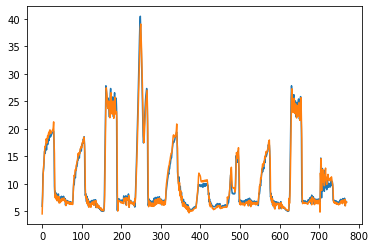

In [6]:
x1 = x[:n_time_steps*10, :]
yp1_ridge = model_ridge.predict(x1)
#yp1_xgb = model_xgb.predict(x1)
y1 = y[:n_time_steps*10]
plt.plot(y1)
plt.plot(yp1_ridge)
#plt.plot(yp1_xgb)